<a href="https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/4_callbacks_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines Tutorial - Callbacks and hyperparameter tuning

Github repo: https://github.com/araffin/rl-tutorial-jnrr19

Stable-Baselines: https://github.com/hill-a/stable-baselines

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines zoo: https://github.com/araffin/rl-baselines-zoo


## Introduction

In this notebook, you will learn how to use *Callbacks* which allow to do monitoring, auto saving, model manipulation, progress bars, ...


You will also see that finding good hyperparameters is key to success in RL.

## Install Dependencies and Stable Baselines Using Pip

In [0]:
# !apt install swig
# !pip install tqdm==4.36.1
# !pip install stable-baselines[mpi]==2.8.0
# # Stable Baselines only supports tensorflow 1.x for now
# %tensorflow_version 1.x

In [1]:
%load_ext autoreload
%autoreload 2
try:
    %%tensorflow_version 1.x
except:
    pass

import os
import sys
lib_path = os.path.abspath('../..')
print('inserting the following to path',lib_path)
if lib_path not in sys.path:
    sys.path.insert(0,lib_path)
print(sys.path)
#-----------------------------------
# Filter tensorflow version warnings
#-----------------------------------
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

inserting the following to path /home/guy/workspace/study/remote/stable-baselines
['/home/guy/workspace/study/remote/stable-baselines/my_colabs/jnrr19', '/home/guy/workspace/study/remote/stable-baselines/my_colabs/jnrr19', '/home/guy/workspace/study/remote/agents', '/home/guy/workspace/study/remote/stable-baselines', '/home/guy/anaconda3/envs/rl15/lib/python37.zip', '/home/guy/anaconda3/envs/rl15/lib/python3.7', '/home/guy/anaconda3/envs/rl15/lib/python3.7/lib-dynload', '', '/home/guy/anaconda3/envs/rl15/lib/python3.7/site-packages', '/home/guy/anaconda3/envs/rl15/lib/python3.7/site-packages/IPython/extensions', '/home/guy/.ipython']


In [3]:
# sys.path.pop(0)
# print(sys.path)

['/home/guy/workspace/study/remote/agents', '/home/guy/workspace/study/remote/stable-baselines', '/home/guy/anaconda3/envs/rl15/lib/python37.zip', '/home/guy/anaconda3/envs/rl15/lib/python3.7', '/home/guy/anaconda3/envs/rl15/lib/python3.7/lib-dynload', '', '/home/guy/anaconda3/envs/rl15/lib/python3.7/site-packages', '/home/guy/anaconda3/envs/rl15/lib/python3.7/site-packages/IPython/extensions', '/home/guy/.ipython']


In [4]:
import gym
from stable_baselines import A2C, SAC, PPO2, TD3

# The importance of hyperparameter tuning

When compared with Supervised Learning, Deep Reinforcement Learning is far more sensitive to the choice of hyper-parameters such as learning rate, number of neurons, number of layers, optimizer ... etc. 
Poor choice of hyper-parameters can lead to poor/unstable convergence. This challenge is compounded by the variability in performance across random seeds (used to initialize the network weights and the environment).

Here we demonstrate on a toy example the [Soft Actor Critic](https://arxiv.org/abs/1801.01290) algorithm applied in the Pendulum environment. Note the change in performance between the default and "tuned" parameters. 

In [6]:
import numpy as np

def evaluate(model, env, num_episodes=100):
    # This function will only work for a single Environment
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    return mean_episode_reward

In [7]:
eval_env = gym.make('Pendulum-v0')

In [8]:
default_model = SAC('MlpPolicy', 'Pendulum-v0', verbose=1).learn(8000)

Creating environment from the given name, wrapped in a DummyVecEnv.
-----------------------------------------
| current_lr              | 0.0003      |
| ent_coef                | 0.86086357  |
| ent_coef_loss           | -0.24097586 |
| entropy                 | 1.0934155   |
| episodes                | 4           |
| fps                     | 116         |
| mean 100 episode reward | -1.4e+03    |
| n_updates               | 500         |
| policy_loss             | 14.504475   |
| qf1_loss                | 0.63816196  |
| qf2_loss                | 0.6681262   |
| time_elapsed            | 5           |
| total timesteps         | 600         |
| value_loss              | 0.05305259  |
-----------------------------------------
----------------------------------------
| current_lr              | 0.0003     |
| ent_coef                | 0.6817271  |
| ent_coef_loss           | -0.5901724 |
| entropy                 | 1.0763786  |
| episodes                | 8          |
| fps         

In [9]:
evaluate(default_model, eval_env, num_episodes=100)

-911.6222794589412

In [10]:
tuned_model = SAC('MlpPolicy', 'Pendulum-v0', batch_size=256, verbose=1, policy_kwargs=dict(layers=[256, 256])).learn(8000)

Creating environment from the given name, wrapped in a DummyVecEnv.
-----------------------------------------
| current_lr              | 0.0003      |
| ent_coef                | 0.9020036   |
| ent_coef_loss           | -0.16898558 |
| entropy                 | 1.2131529   |
| episodes                | 4           |
| fps                     | 147         |
| mean 100 episode reward | -1.35e+03   |
| n_updates               | 345         |
| policy_loss             | 12.203175   |
| qf1_loss                | 0.22476763  |
| qf2_loss                | 0.22148173  |
| time_elapsed            | 4           |
| total timesteps         | 600         |
| value_loss              | 0.0542944   |
-----------------------------------------
-----------------------------------------
| current_lr              | 0.0003      |
| ent_coef                | 0.7152608   |
| ent_coef_loss           | -0.48915467 |
| entropy                 | 1.0975705   |
| episodes                | 8           |
| fps   

In [11]:
evaluate(tuned_model, eval_env, num_episodes=100)

-160.04670914775298

Exploring hyperparameter tuning is out of the scope (and time schedule) of this tutorial. However, you need to know that we provide tuned hyperparameter in the [rl zoo](https://github.com/araffin/rl-baselines-zoo) as well as automatic hyperparameter optimization using [Optuna](https://github.com/pfnet/optuna).

<font color='red'> TODO : have a deeper look at the above links </font>

## Helper functions
This is to help the callbacks store variables (as they are function), but this could be also done by passing a class method.

In [12]:
def get_callback_vars(model, **kwargs): 
    """
    Helps store variables for the callback functions
    :param model: (BaseRLModel)
    :param **kwargs: initial values of the callback variables
    """
    # save the called attribute in the model
    if not hasattr(model, "_callback_vars"): 
        model._callback_vars = dict(**kwargs)
    else: # check all the kwargs are in the callback variables
        for (name, val) in kwargs.items():
            if name not in model._callback_vars:
                model._callback_vars[name] = val
    return model._callback_vars # return dict reference (mutable)

# Callbacks

## A functional approach
A callback function takes the `locals()` variables and the `globals()` variables from the model, then returns a boolean value for whether or not the training should continue.

Thanks to the access to the models variables, in particular `_locals["self"]`, we are able to even change the parameters of the model without halting the training, or changing the model's code.

Here we have a simple callback that can only be called twice:

In [13]:
def simple_callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """ 
    # get callback variables, with default values if unintialized
    callback_vars = get_callback_vars(_locals["self"], called=False) 
    
    if not callback_vars["called"]:
        print("callback - first call")
        callback_vars["called"] = True
        return True # returns True, training continues.
    else:
        print("callback - second call")
        return False # returns False, training stops.

model = SAC('MlpPolicy', 'Pendulum-v0', verbose=1)
model.learn(8000, callback=simple_callback)

Creating environment from the given name, wrapped in a DummyVecEnv.
callback - first call
callback - second call


## First example: Auto saving best model
In RL, it is quite useful to keep a clean version of a model as you are training, as we can end up with burn-in of a bad policy. This is a typical use case for callback, as they can call the save function of the model, and observe the training over time.

Using the monitoring wrapper, we can save statistics of the environment, and use them to determine the mean training reward.
This allows us to save the best model while training.

Note that this is not the proper way of evaluating an RL agent, you should create an test environment and evaluate the agent performance in the callback. For simplicity, we will be using the training reward as a proxy.

In [14]:
import os

import numpy as np

from stable_baselines.bench import Monitor
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.results_plotter import load_results, ts2xy

def auto_save_callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    # get callback variables, with default values if unintialized
    callback_vars = get_callback_vars(_locals["self"], n_steps=0, best_mean_reward=-np.inf) 

    # skip every 20 steps
    if callback_vars["n_steps"] % 20 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])

            # New best model, you could save the agent here
            if mean_reward > callback_vars["best_mean_reward"]:
                callback_vars["best_mean_reward"] = mean_reward
                # Example for saving best model
                print("Saving new best model at {} timesteps".format(x[-1]))
                _locals['self'].save(log_dir + 'best_model')
    callback_vars["n_steps"] += 1
    return True

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('CartPole-v1')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000, callback=auto_save_callback)

Saving new best model at 104 timesteps
Saving new best model at 192 timesteps
Saving new best model at 285 timesteps
Saving new best model at 369 timesteps
Saving new best model at 504 timesteps
Saving new best model at 694 timesteps
Saving new best model at 1196 timesteps
Saving new best model at 1299 timesteps
Saving new best model at 1356 timesteps
Saving new best model at 1499 timesteps
Saving new best model at 1695 timesteps
Saving new best model at 1800 timesteps
Saving new best model at 3002 timesteps
Saving new best model at 3356 timesteps
Saving new best model at 3482 timesteps
Saving new best model at 3705 timesteps
Saving new best model at 4794 timesteps
Saving new best model at 4870 timesteps
Saving new best model at 4983 timesteps
Saving new best model at 5098 timesteps
Saving new best model at 5254 timesteps
Saving new best model at 5495 timesteps
Saving new best model at 5594 timesteps
Saving new best model at 5958 timesteps
Saving new best model at 6093 timesteps
Saving

## Second example: Realtime plotting of performance
While training, it is sometimes useful to how the training progresses over time, relative to the episodic reward.
For this, Stable-Baselines has [Tensorboard support](https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html), however this can be very combersome, especially in disk space usage. 

**NOTE: Unfortunately live plotting does not work out of the box on google colab**

Here, we can use callback again, to plot the episodic reward in realtime, using the monitoring wrapper:

<IPython.core.display.Javascript object>


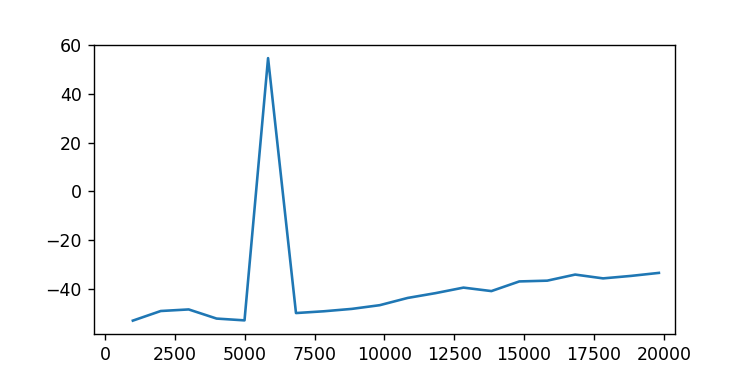

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

def plotting_callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    # get callback variables, with default values if unintialized
    callback_vars = get_callback_vars(_locals["self"], plot=None) 
    
    # get the monitor's data
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    if callback_vars["plot"] is None: # make the plot
        plt.ion()
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(111)
        line, = ax.plot(x, y)
        callback_vars["plot"] = (line, ax, fig)
        plt.show()
    else: # update and rescale the plot
        callback_vars["plot"][0].set_data(x, y)
        callback_vars["plot"][-2].relim()
        callback_vars["plot"][-2].set_xlim([_locals["total_timesteps"] * -0.02, 
                                            _locals["total_timesteps"] * 1.02])
        callback_vars["plot"][-2].autoscale_view(True,True,True)
        callback_vars["plot"][-1].canvas.draw()
        
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('MountainCarContinuous-v0')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])
        
model = PPO2('MlpPolicy', env, verbose=0)
model.learn(20000, callback=plotting_callback)

## Third example: Progress bar
Quality of life improvement are always welcome when developping and using RL. Here, we used [tqdm](https://tqdm.github.io/) to show a progress bar of the training, along with number of timesteps per second and the estimated time remaining to the end of the training:

In [16]:
from tqdm.auto import tqdm

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class progressbar_callback(object):
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
        
        def callback_progressbar(local_, global_):
            self.pbar.n = local_["self"].num_timesteps
            self.pbar.update(0)
            
        return callback_progressbar

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()
        
model = TD3('MlpPolicy', 'Pendulum-v0', verbose=0)
with progressbar_callback(2000) as callback: # this the garanties that the tqdm progress bar closes correctly
    model.learn(2000, callback=callback)

## Forth example: Composition
Thanks to the functional nature of callbacks, it is possible to do a composition of callbacks, into a single callback. This means we can auto save our best model, show the progess bar and episodic reward of the training:

<IPython.core.display.Javascript object>


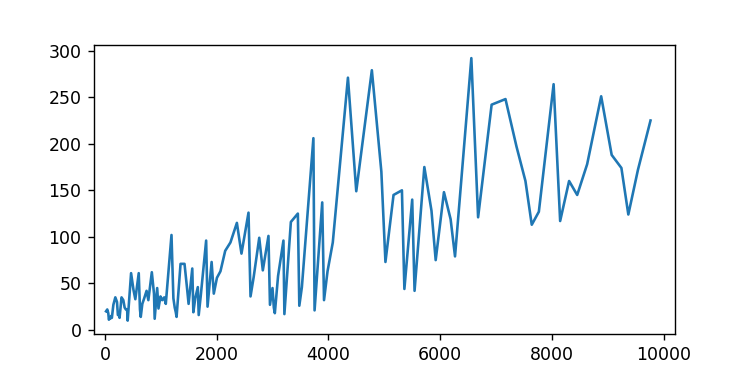

Saving new best model at 124 timesteps
Saving new best model at 2662 timesteps
Saving new best model at 5164 timesteps
Saving new best model at 7764 timesteps



In [17]:
%matplotlib notebook

def compose_callback(*callback_funcs): # takes a list of functions, and returns the composed function.
    def _callback(_locals, _globals):
        continue_training = True
        for cb_func in callback_funcs:
            if cb_func(_locals, _globals) is False: # as a callback can return None for legacy reasons.
                continue_training = False
        return continue_training
    return _callback

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('CartPole-v1')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

model = PPO2('MlpPolicy', env, verbose=0)
with progressbar_callback(10000) as progress_callback:
    model.learn(10000, callback=compose_callback(progress_callback, plotting_callback, auto_save_callback))

## Exercise: Code your own callback


The previous examples showed the basics of what is a callback and what you do with it.

The goal of this exercise is to create a callback that will evaluate the model using a test environment and save it if this is the best known model.

To make things easier, we are going to use a class instead of a function with the magic method `__call__`.

In [0]:
class EvalCallback(object):
  """
  Callback for evaluating an agent.
  
  :param eval_env: (gym.Env) The environment used for initialization
  :param n_eval_episodes: (int) The number of episodes to test the agent
  :param eval_freq: (int) Evaluate the agent every eval_freq call of the callback.
  """
  def __init__(self, eval_env, n_eval_episodes=5, eval_freq=20):
    super(EvalCallback, self).__init__()
    self.eval_env = eval_env
    self.n_eval_episodes = n_eval_episodes
    self.eval_freq = eval_freq
    self.n_calls = 0
    self.best_mean_reward = -np.inf
  
  def __call__(self, locals_, globals_):
    """
    This method will be called by the model. This is the equivalent to the callback function
    used the previous examples.
    :param locals_: (dict)
    :param globals_: (dict)
    :return: (bool)
    """
    # Get the self object of the model
    self_ = locals_['self']
    
    if self.n_calls % self.eval_freq == 0:
      # === YOUR CODE HERE ===#
      # Evaluate the agent:
      # you need to do self.n_eval_episodes loop using self.eval_env
      # hint: you can use self_.predict(obs)
      
      # Save the agent if needed
      # and update self.best_mean_reward
      
      print("Best mean reward: {:.2f}".format(self.best_mean_reward))
      

      # ====================== #
    
    self.n_calls += 1
    
    return True

### Test your callback

In [0]:
# Env used for training
env = gym.make("CartPole-v1")
# Env for evaluating the agent
eval_env gym.make("CartPole-v1")

# === YOUR CODE HERE ===#
# Create the callback object
callback = None

# Create the RL model
model = None

# ====================== #

# Train the RL model
model.learn(int(100000), callback=callback)


# Conclusion


In this notebook we have seen:
- that good hyperparameters are key to the success of RL, you should not except the default ones to work on every problems
- what is a callback and what you can do with it
- how to create your own callback
